In [29]:
import numpy as np
import urllib3
import os
import matplotlib.pyplot as plt

def open_matrix(filename='outfile_kuba.txt'):
    with open(filename, 'r') as f:
        l = [[int(float(num)) for num in line.split(' ')] for line in f]
    return l


def get_coco_labels():
    http = urllib3.PoolManager()
    r = http.request('GET', 'https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt')
    dane = r.data.decode('UTF-8')
    my_data = dane.split('\n')

    coco = {i+1: my_data[i] for i in range(0,len(my_data))}
    coco.pop(91) # remove hairbrush
    return coco

In [25]:
coco = get_coco_labels()

coco_readable_to_index = {value:key for key, value in coco.items()}

def get_all_detections(confusion_matrix, class_name):
    return confusion_matrix[coco_readable_to_index[class_name]-1][:-1]

def get_TP(confusion_matrix, class_name):
    return confusion_matrix[coco_readable_to_index[class_name]-1][coco_readable_to_index[class_name]-1]

# not detected
def get_FN(confusion_matrix, class_name):
    return confusion_matrix[coco_readable_to_index[class_name]-1][-1]

def get_FP(confusion_matrix, class_name):
    return sum(get_all_detections(confusion_matrix, class_name)) - get_TP(class_name)



def get_precision(confusion_matrix, class_name):
    return get_TP(confusion_matrix, class_name) / get_all_detections(confusion_matrix, class_name)

def get_recall(confusion_matrix, class_name):
    return get_TP(confusion_matrix, class_name) / ((get_TP(confusion_matrix, class_name))+get_FN(confusion_matrix, class_name))

def get_F1_score(confusion_matrix, class_name):
    numerator = 2 * get_TP(confusion_matrix, class_name)
    denominator = numerator + get_FP(confusion_matrix, class_name) + get_FN(confusion_matrix, class_name)

    return numerator/denominator

def get_normalized(confusion_matrix, class_name):
    tmp = []
    for row in confusion_matrix:
        normalized_row = []
        for value in row:
            normalized_row.append(value/(sum(row)))
        tmp.append(normalized_row)

    return tmp[coco_readable_to_index[class_name]-1][coco_readable_to_index[class_name]-1]



def read_matrices(model_name):
    matrices = []
    files = os.listdir(model_name)
    for file in files:
        if file.endswith(".txt"):
            resolution = file.split("_")[0]
            if resolution.split("x")[0] != "None":
                resolution_int = int(resolution.split("x")[0]) * int(resolution.split("x")[1])
            else:
                resolution_int = 0
            matrices.append((resolution_int, resolution, open_matrix(model_name + "\\" + file)))

    matrices.sort(key = lambda x: x[0])
    return matrices

In [23]:
def get_normalized_for_resolutions(matrices_with_res , class_name):
    normalized_with_res = []
    for resolution in matrices_with_res:
        normalized_with_res.append((resolution[0], resolution[1], get_normalized(resolution[2],class_name)))

    return normalized_with_res

In [60]:
def draw(resolutions_with_values, name="normalized"):
    plt.rcParams["figure.figsize"] = (20,10)
    values = [i[2] for i in resolutions_with_values]
    labels = [i[1] for i in resolutions_with_values]
    x_positions = np.arange(len(resolutions_with_values))
    plt.plot(x_positions, values, color='red',linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12 )
    plt.xticks(x_positions, labels)
    plt.tick_params(axis="both", labelsize=18)
    plt.title(name)
    plt.xlabel("resolution", fontsize=20)
    plt.ylabel("value", fontsize=20)
    plt.show()



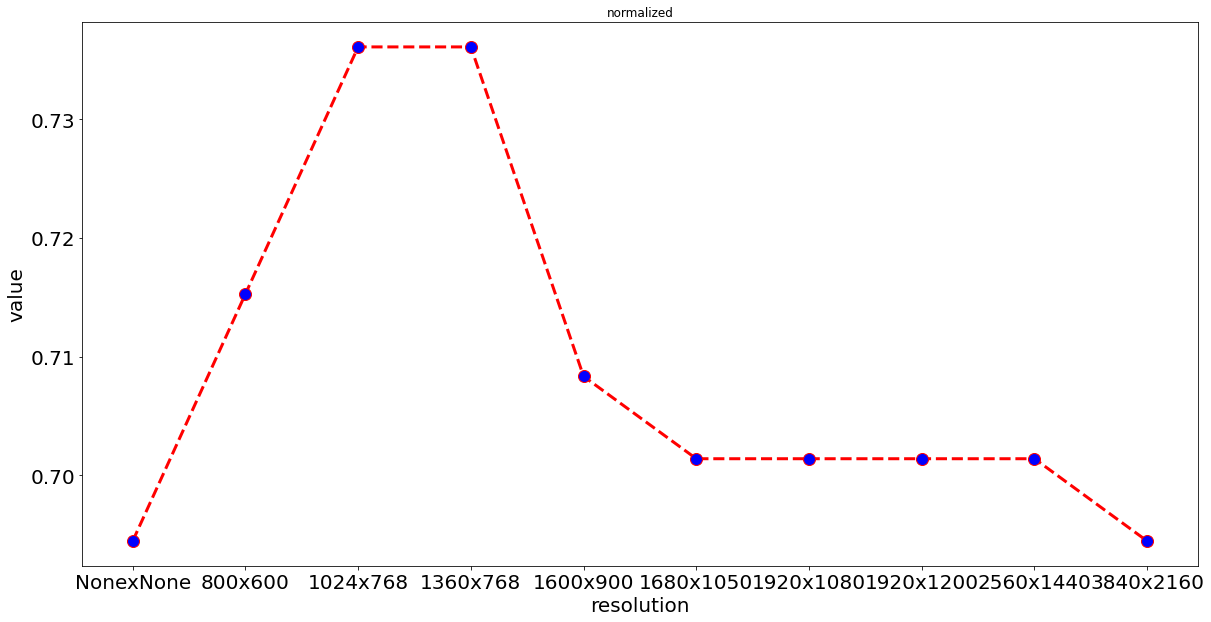

In [59]:

matrices_with_res = read_matrices("ssd+mobilenet_v2")
normalized = get_normalized_for_resolutions(matrices_with_res, 'truck')
# x -> resolution
# y - f1 normalized etc
draw(normalized)